In [1]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot as plt
import quantum_classical_LHCdata as qc

import tensorflow as tf
from matplotlib import pyplot
from qibo import gates, hamiltonians, models, set_backend, set_threads
from matplotlib import cm
from matplotlib import pyplot as plt, colors
from matplotlib.offsetbox import AnchoredText
import plots_LHC as plhc
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from scipy.stats import entropy

[Qibo 0.1.6|INFO|2022-05-18 07:33:08]: Using numpy backend on /CPU:0
[Qibo 0.1.6|WARNING|2022-05-18 07:33:08]: numpy backend uses `np.einsum` and supports CPU only. Consider installing the qibojit or qibotf backends for increased performance and to enable GPU acceleration.
[Qibo 0.1.6|INFO|2022-05-18 07:33:09]: Using tensorflow backend on /device:CPU:0
[Qibo 0.1.6|WARNING|2022-05-18 07:33:09]: `set_threads` is not supported by the tensorflow backend. Please use tensorflow's thread setters: `tf.config.threading.set_inter_op_parallelism_threads` or `tf.config.threading.set_intra_op_parallelism_threads` to switch the number of threads.


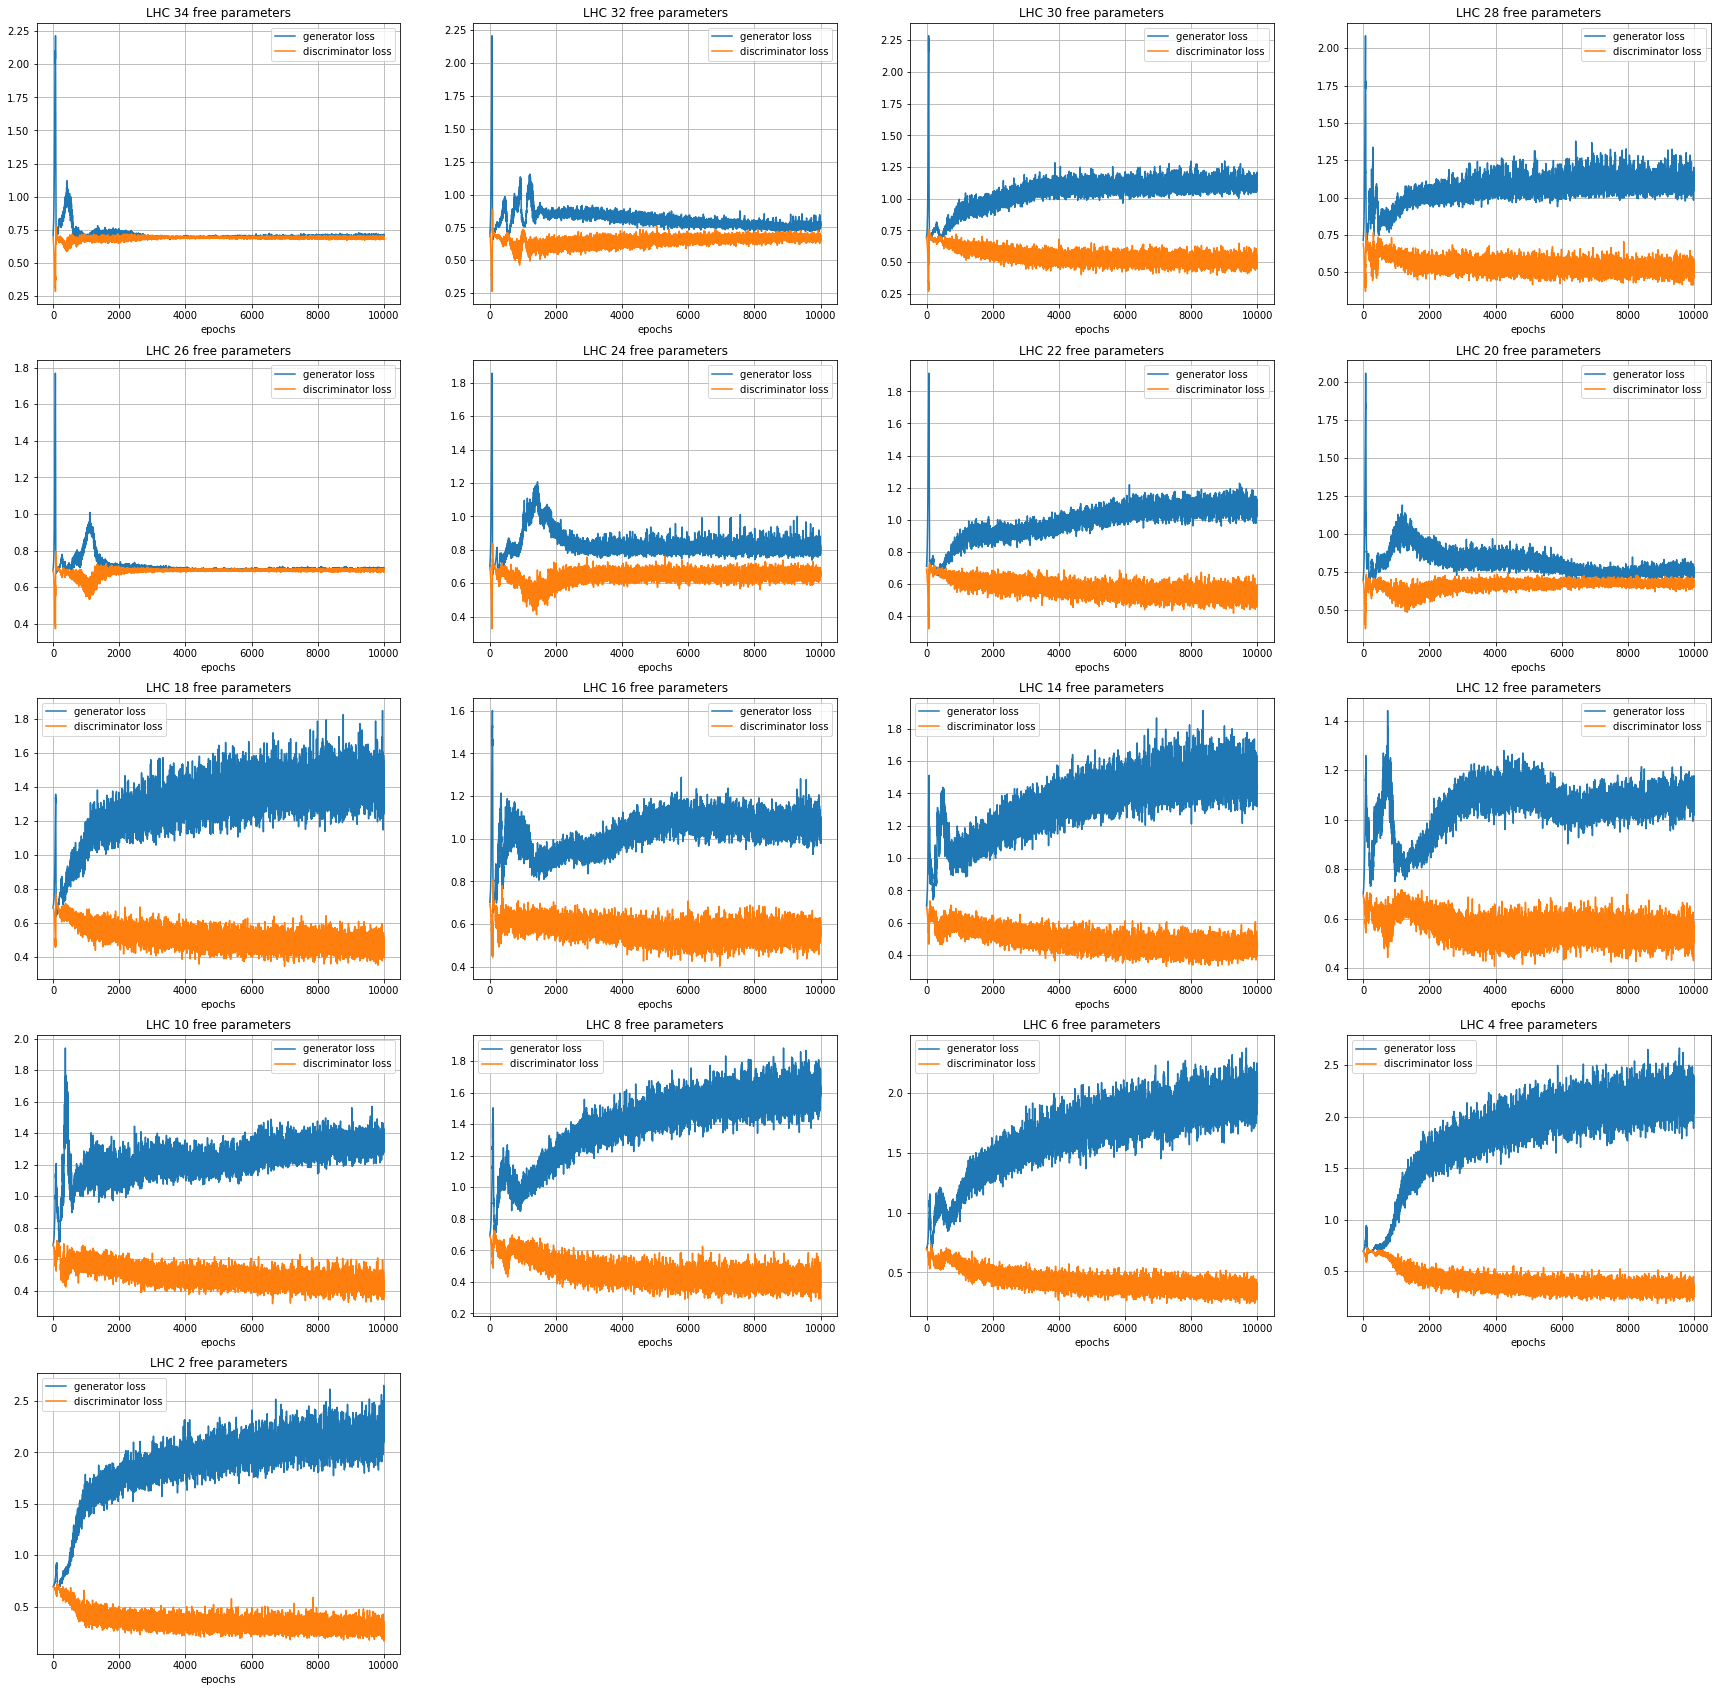

In [3]:
n_layers=128
fixed_params=range(0,34,2)
pyplot.figure(figsize=(30,30))
rows=5
cols=4


for i, val in enumerate(fixed_params):
    
    pyplot.subplot(rows,cols,i+1)
    
    d_loss = np.loadtxt(f"results/dloss_transfer_learning_LHCdata_3_3_2_10000_128_0.1_{val}", delimiter=' ')
    g_loss= np.loadtxt(f"results/gloss_transfer_learning_LHCdata_3_3_2_10000_128_0.1_{val}", delimiter=' ')
   
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), g_loss, label='generator loss')
    pyplot.plot(np.linspace(0, len(g_loss), len(g_loss)), d_loss, label='discriminator loss')
    pyplot.title(f'LHC {34-val} free parameters')
    pyplot.xlabel('epochs')
    pyplot.legend()
    pyplot.grid()

pyplot.show()

generating real samples
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[-0.86655282  2.47191242  1.00564242]
MinMaxScaler(copy=True, feature_range=(-1, 1))
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[-0.86655282  2.47191242  1.00564242]
MinMaxScaler(copy=True, feature_range=(-1, 1))
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[-0.86655282  2.47191242  1.00564242]
MinMaxScaler(copy=True, feature_range=(-1, 1))
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[-0.86655282  2.47191242  1.00564242]
MinMaxScaler(copy=True, feature_range=(-1, 1))
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[-0.86655282  2.47191242  1.00564242]
MinMaxScaler(copy=True, feature_range=(-1, 1))
PowerTransformer(copy=True, method='yeo-johnson', standardize=True)
[-0.86655282  2.47191242  1.00564242]
MinMaxScaler(copy=True, feature_range=(-1, 1))
PowerTransformer(copy=True, method='yeo-johnson', standard

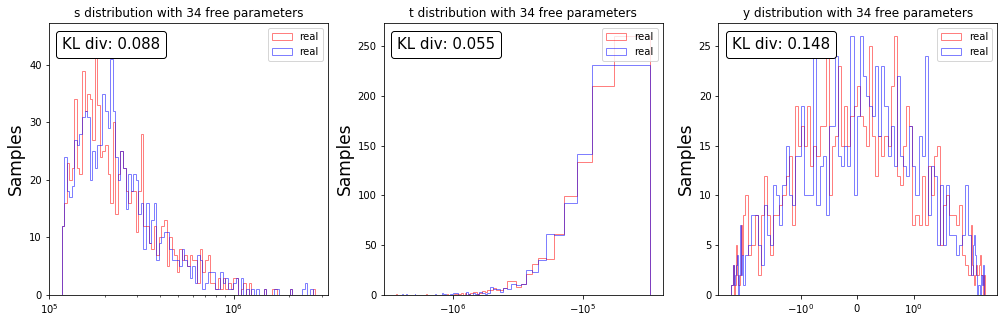

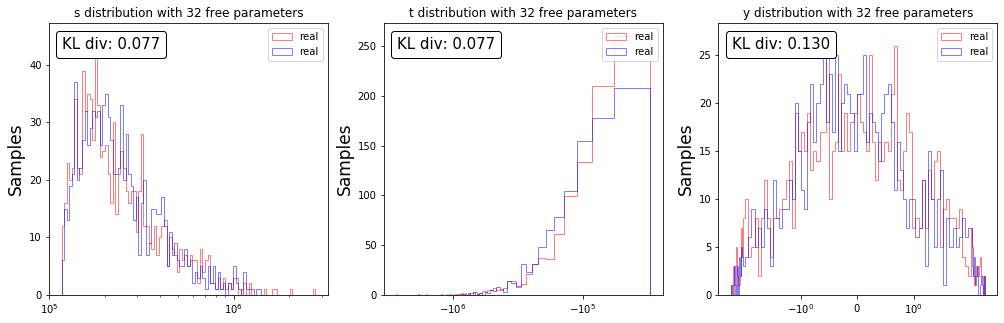

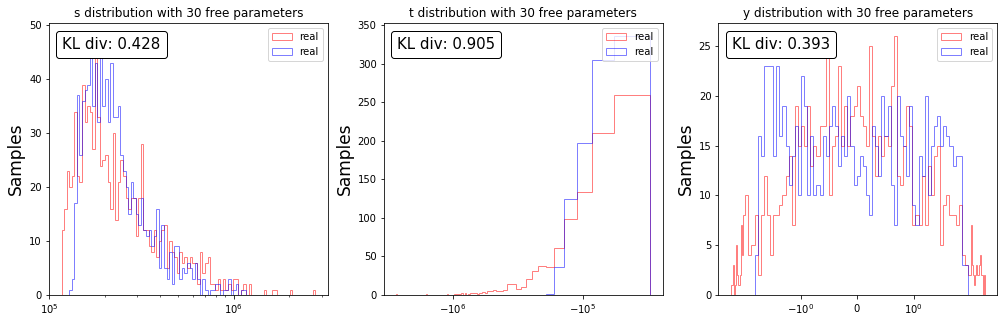

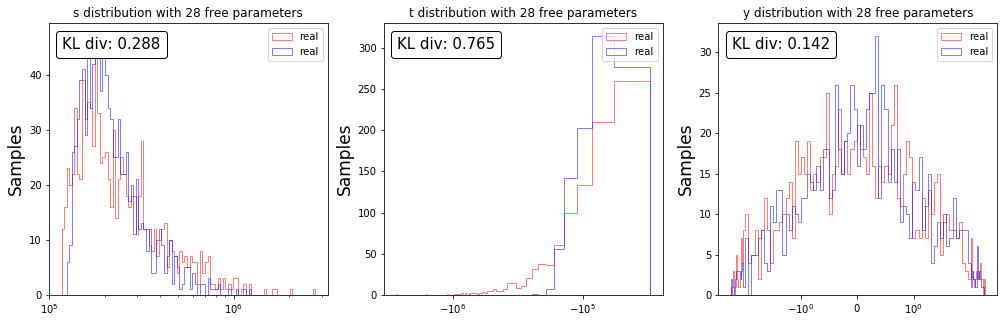

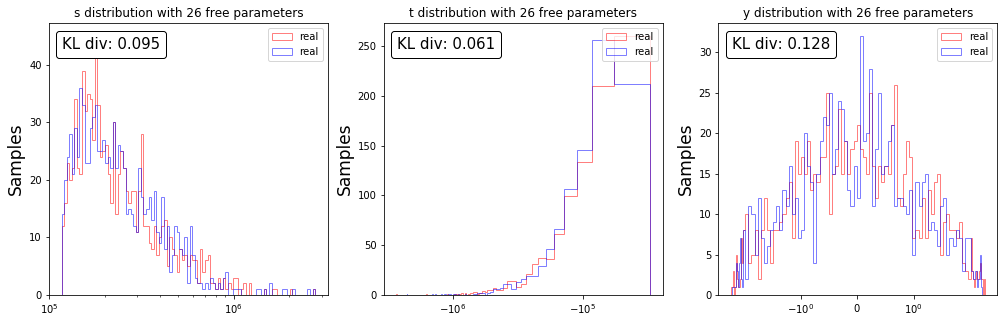

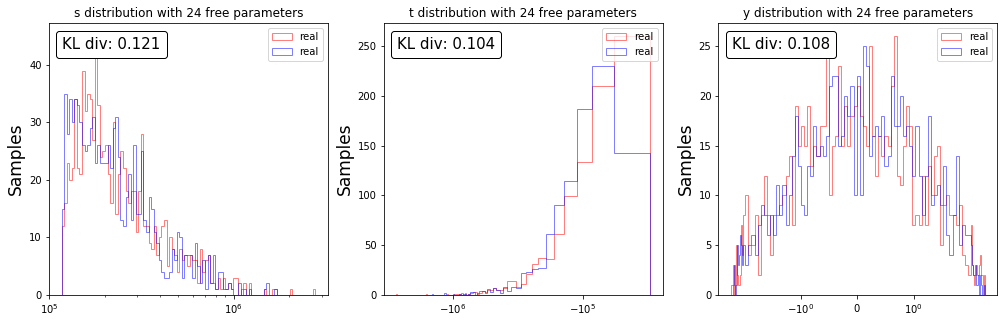

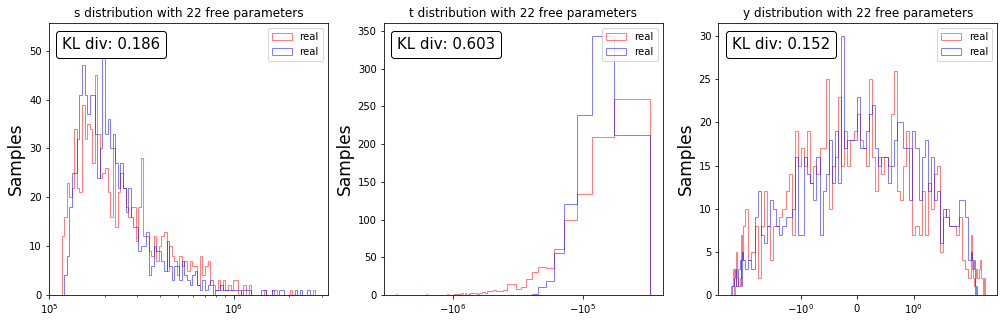

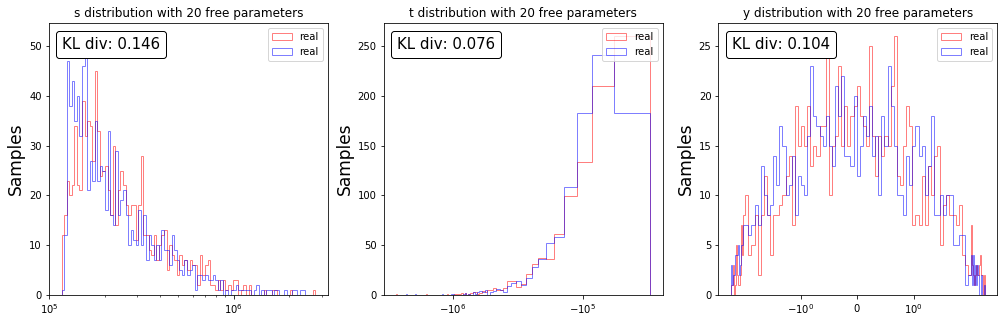

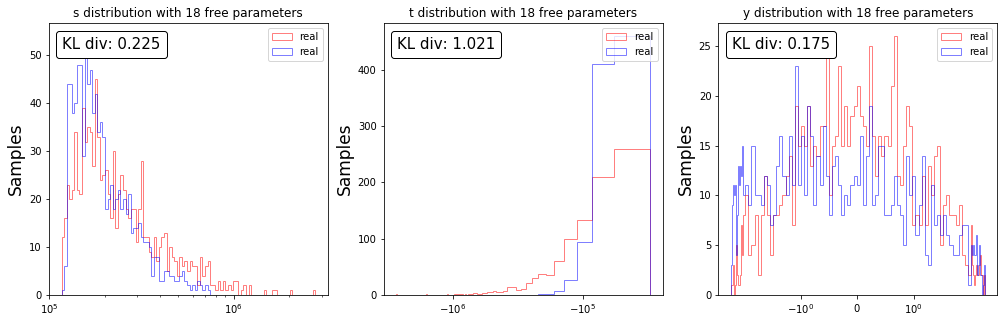

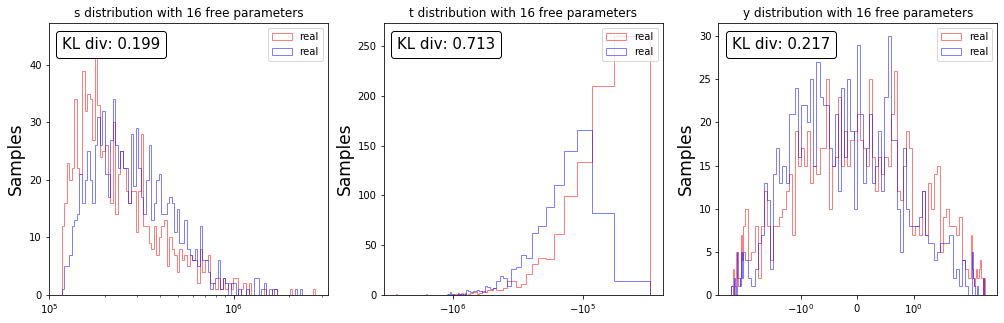

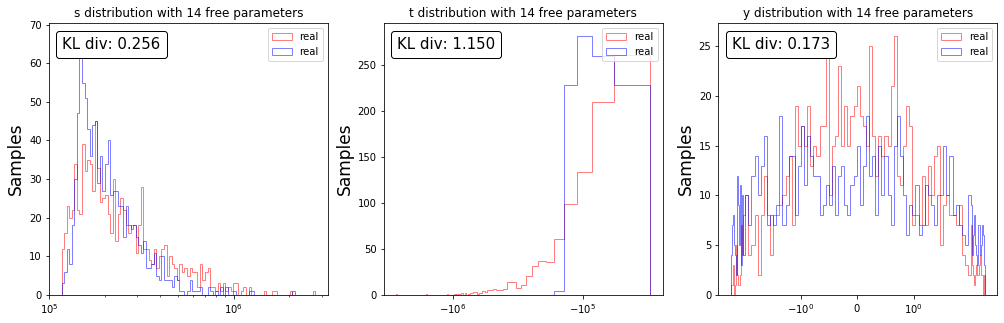

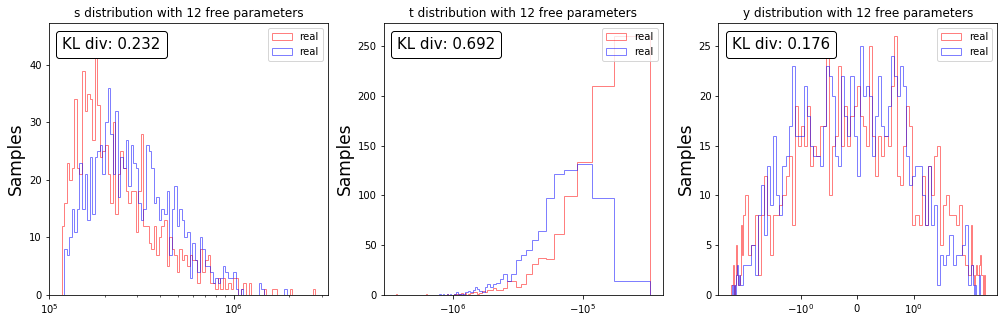

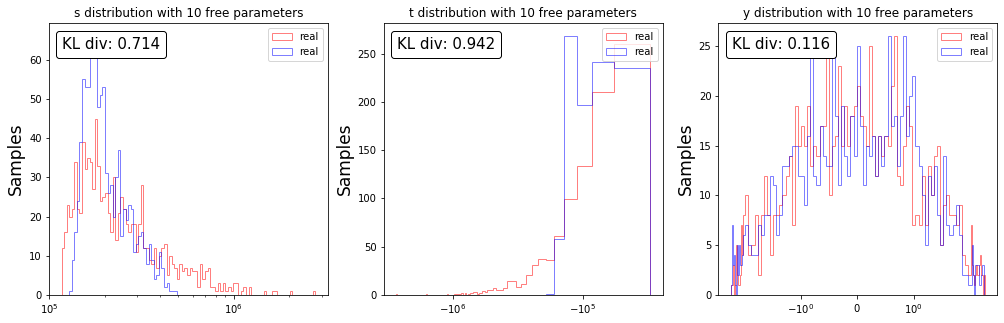

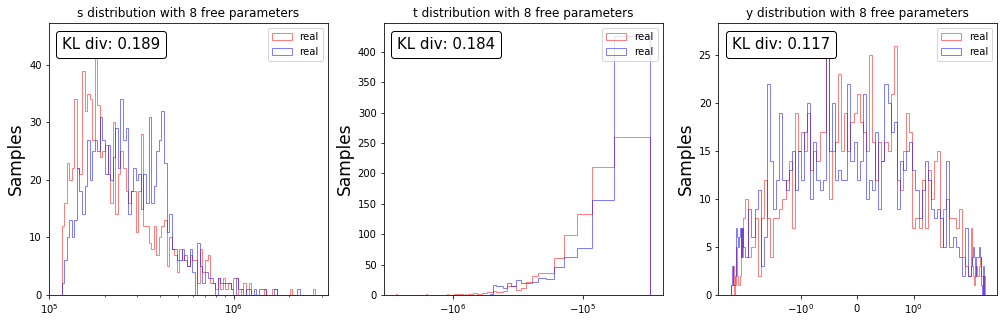

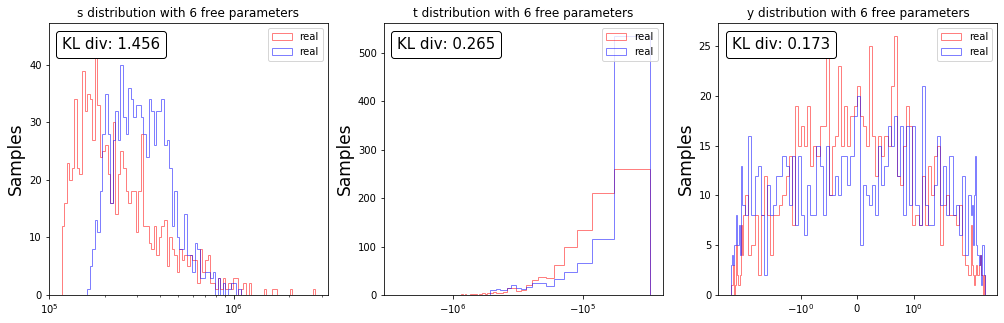

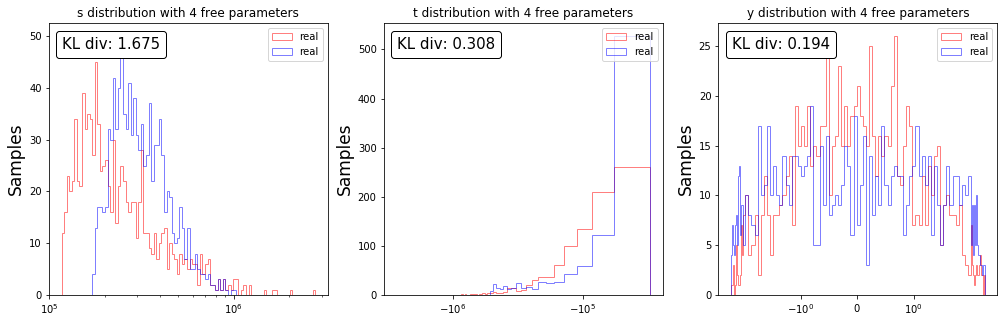

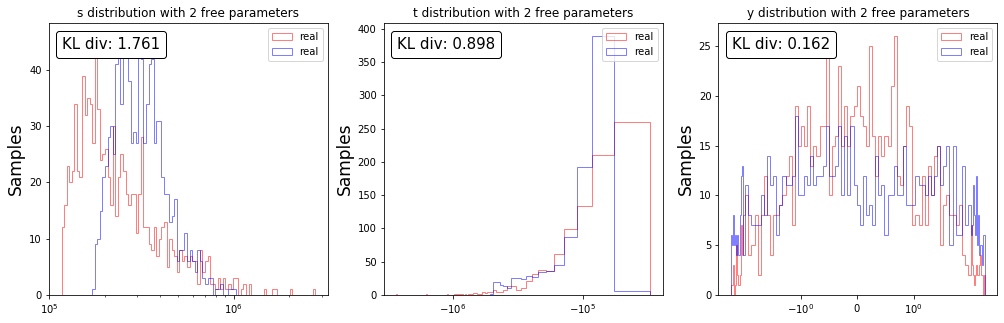

In [28]:
def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems
   
# define hamiltonian to generate fake samples
def hamiltonian1():
    id = [[1, 0], [0, 1]]
    m0 = hamiltonians.Z(1).matrix
    m0 = np.kron(id, np.kron(id, m0))
    ham = hamiltonians.Hamiltonian(3, m0)
    return ham

def hamiltonian2():
    id = [[1, 0], [0, 1]]
    m0 = hamiltonians.Z(1).matrix
    m0 = np.kron(id, np.kron(m0, id))
    ham = hamiltonians.Hamiltonian(3, m0)
    return ham

def hamiltonian3():
    id = [[1, 0], [0, 1]]
    m0 = hamiltonians.Z(1).matrix
    m0 = np.kron(m0, np.kron(id, id))
    ham = hamiltonians.Hamiltonian(3, m0)
    return ham

layers = 2
training_samples = 10000
n_epochs = 30000
batch_samples = 128
lr = 0.1
n_params = 0
latent_dim = 3
bins=100

# number of qubits generator
nqubits = 3
# create hamiltonians
hamiltonian1 = hamiltonian1()
hamiltonian2 = hamiltonian2()
hamiltonian3 = hamiltonian3()
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
    if l==1 or l==5 or l==9 or l==13 or l==17:
        circuit.add(gates.CRY(0, 1, 0))
        circuit.add(gates.CRY(0, 2, 0))
    if l==3 or l==7 or l==11 or l==15 or l==19:
        circuit.add(gates.CRY(1, 2, 0))
        circuit.add(gates.CRY(2, 0, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0))

nqubits = 3

samples = 1000
nbins = 100
print('generating real samples')
x_real = plhc.load_events('data/ppttbar_10k_events.lhe')
x_real1 = []
x_real2 = []
x_real3 = []
for i in range(samples):
    x_real1.append(x_real[i][0])
    x_real2.append(x_real[i][1])
    x_real3.append(x_real[i][2])

fixed_params=range(0,34,2)
fparams = np.loadtxt(f"fixed_PARAMS")
s_kl=[]
t_kl=[]
y_kl=[]
for i, val in enumerate(fixed_params):
    
    params = np.loadtxt(f"results/PARAMS_transfer_learning_LHCdata_{nqubits}_{latent_dim}_{layers}_{training_samples}_{batch_samples}_{lr}_{val}")

    
    #print(len(params))
    params= np.append(fparams[:val:],params)
    #print(len(params))
    x_fake, _ = plhc.generate_fake_samples(circuit, params, latent_dim, samples, nqubits, layers, hamiltonian1, hamiltonian2, hamiltonian3)
    
    init = plhc.readInit('data/ppttbar_10k_events.lhe')
    evs = list(plhc.readEvent('data/ppttbar_10k_events.lhe'))    
    invar = np.zeros((len(evs),3))
    for ev in range(len(evs)):
         invar[ev, 0] = plhc.GetEnergySquared(evs[ev])
         invar[ev, 1] = plhc.GetMandelT(evs[ev])
         invar[ev, 2] = plhc.GetRapidity(init, evs[ev])         
    pt = PowerTransformer()
    print(pt.fit(invar[:10000, :]))
    print(pt.lambdas_)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    print(scaler.fit(pt.transform(invar[:10000, :])))

    x_fake = pt.inverse_transform(scaler.inverse_transform(x_fake))
    x_fake1 = []
    x_fake2 = []
    x_fake3 = []
   
    for i in range(samples):
        x_fake1.append(x_fake[i][0])
        x_fake2.append(x_fake[i][1])
        x_fake3.append(x_fake[i][2])
    #print(x_fake1)
    #print(x_real1)
    #print('1D distributions')
    fig = plt.figure(figsize=[17,5])
    
    plt.subplot(1,3,1)
    bins_real=pyplot.hist(x_real1, bins = np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins),histtype='step', color='red', label='real', alpha=0.5)
    
    bins_fake=pyplot.hist(x_fake1, bins = np.logspace(np.log10(min(x_real1)),np.log10(max(x_real1)),bins),histtype='step', color='blue', label='real', alpha=0.5)
    
    #print(bins_real,bins_fake)
    kl=kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)
    s_kl.append(kl)
    ax=pyplot.gca()
    at = AnchoredText(
    f"KL div: {'%.3f' %kl}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    #pyplot.text( 0.,0.,"prova", bbox=dict(facecolor='red', alpha=0.5))
    #pyplot.xlim(-1,1)
    pyplot.xscale('log')
    pyplot.title(f's distribution with {34-val} free parameters')
    pyplot.legend()
    plt.ylabel('Samples', fontsize=17)
    plt.xlabel('', fontsize=17)
    
    plt.subplot(1,3,2)
    bins_real=pyplot.hist(x_real2, bins =bins,histtype='step', color='red', label='real', alpha=0.5)
    bins_fake=pyplot.hist(x_fake2, bins =bins_real[1],histtype='step', color='blue', label='real', alpha=0.5)
    kl = kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)
    t_kl.append(kl)
    ax=pyplot.gca()
    at = AnchoredText(
    f"KL div: {'%.3f' %kl}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    #pyplot.text( 0.,0.,"prova", bbox=dict(facecolor='red', alpha=0.5))
    #pyplot.xlim(-1,1)
    pyplot.xscale('symlog')
    pyplot.title(f't distribution with {34-val} free parameters')
    pyplot.legend()
    plt.ylabel('Samples', fontsize=17)
    plt.xlabel('', fontsize=17)
    
    plt.subplot(1,3,3)
    bins_real=pyplot.hist(x_real3, bins =bins,histtype='step', color='red', label='real', alpha=0.5)
    bins_fake=pyplot.hist(x_fake3, bins =bins_real[1],histtype='step', color='blue', label='real', alpha=0.5)
    kl= kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)
    y_kl.append(kl)
    ax=pyplot.gca()
    at = AnchoredText(
    f"KL div: {'%.3f' %kl}", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    #pyplot.text( 0.,0.,"prova", bbox=dict(facecolor='red', alpha=0.5))
    #pyplot.xlim(-1,1)
    pyplot.xscale('symlog')
    pyplot.title(f'y distribution with {34-val} free parameters')
    pyplot.legend()
    plt.ylabel('Samples', fontsize=17)
    plt.xlabel('', fontsize=17)


Text(0, 0.5, 'kl div')

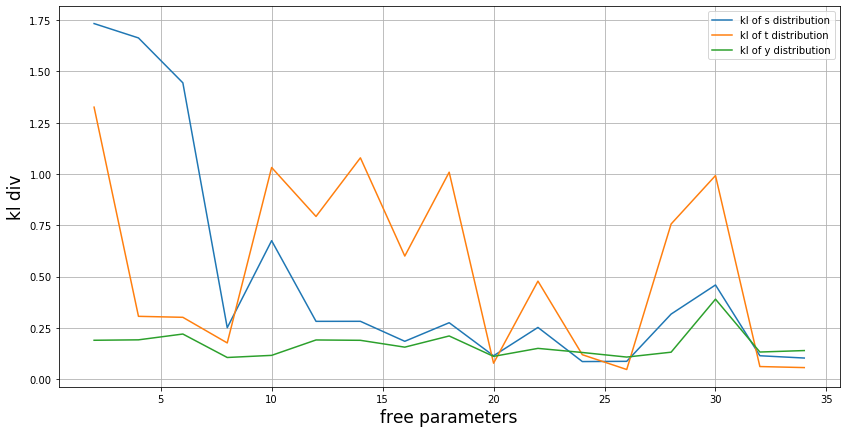

In [5]:
plt.figure(figsize=(14,7))
plt.plot(range(34,0,-2),s_kl,label="kl of s distribution")
plt.plot(range(34,0,-2),t_kl,label="kl of t distribution")
plt.plot(range(34,0,-2),y_kl,label="kl of y distribution")
plt.legend()
plt.grid()
plt.xlabel("free parameters",fontsize=17)
plt.ylabel("kl div",fontsize=17)

with 24 free parameters the performances are better than the case with 34 

prova
prova3


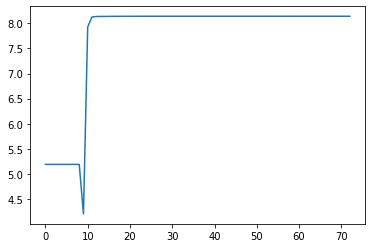

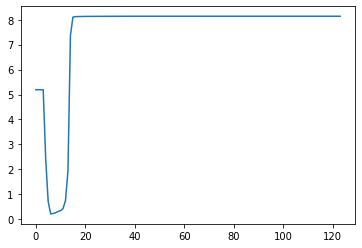

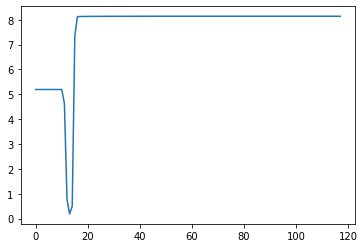

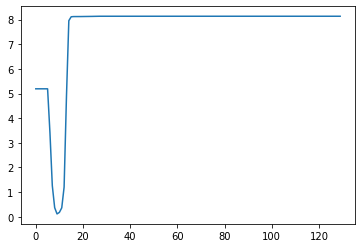

prova3


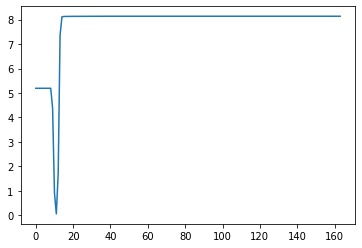

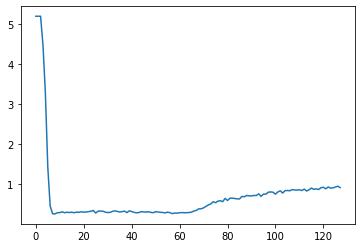

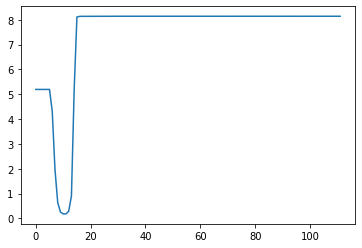

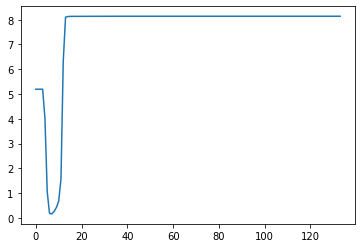

prova3


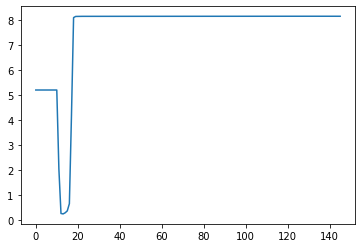

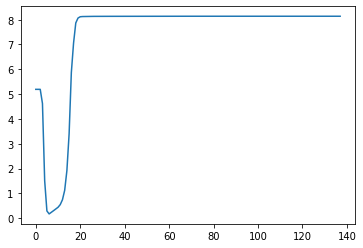

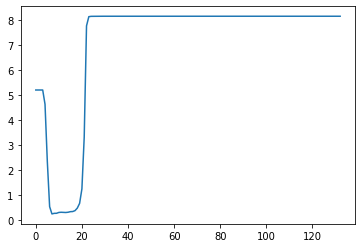

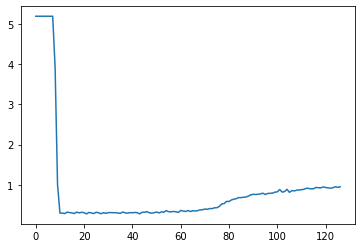

prova3


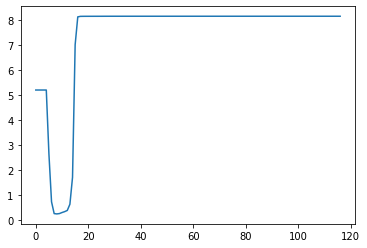

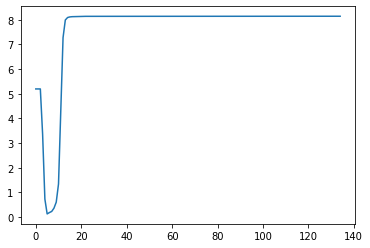

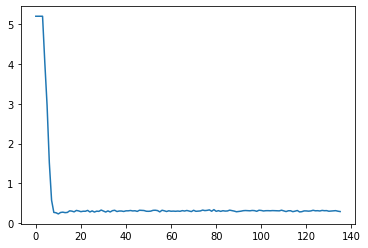

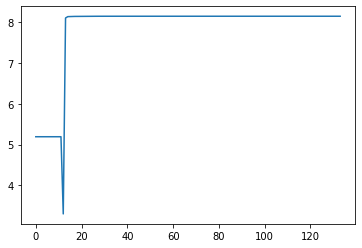

prova3


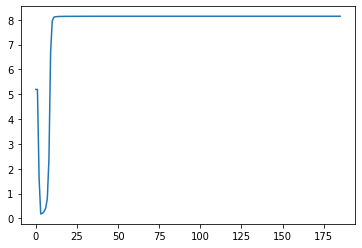

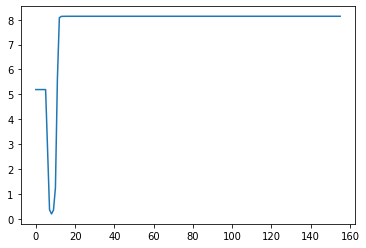

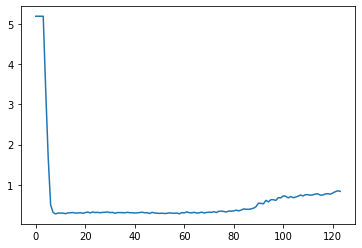

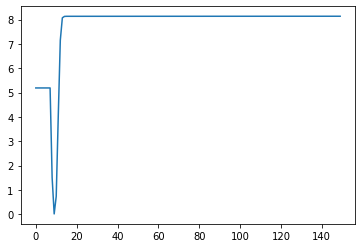

prova3


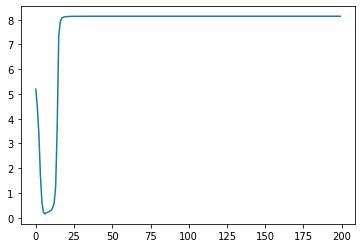

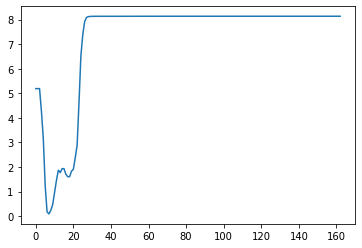

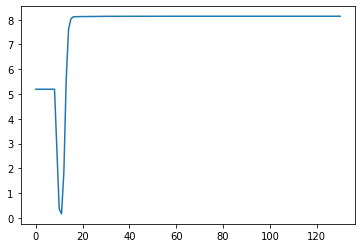

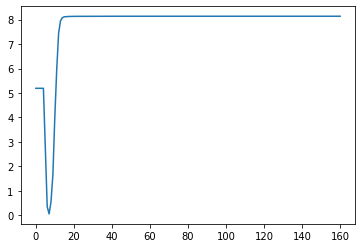

prova3


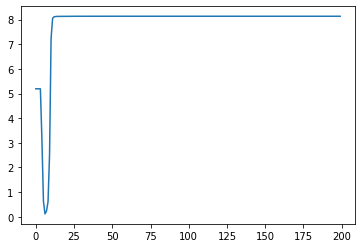

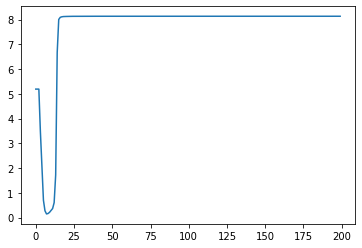

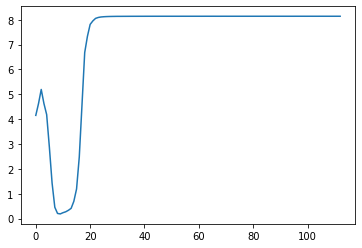

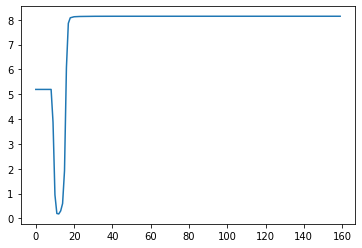

prova3


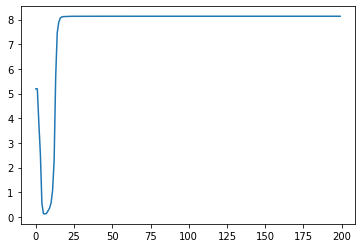

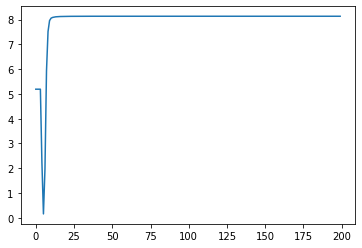

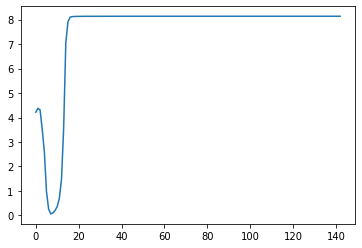

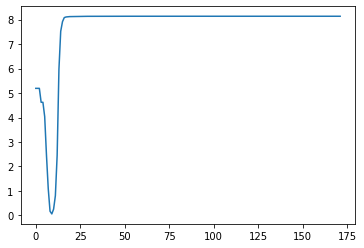

prova3


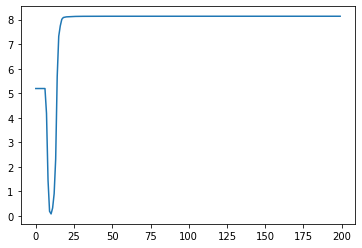

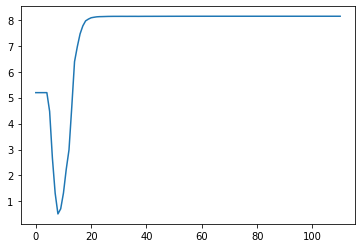

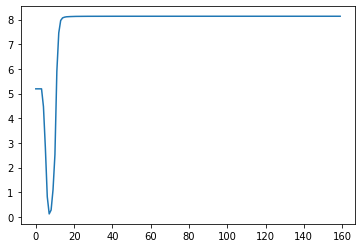

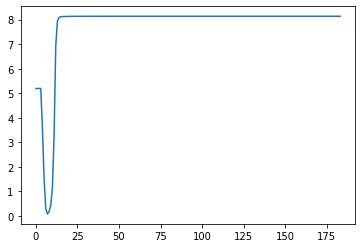

prova3


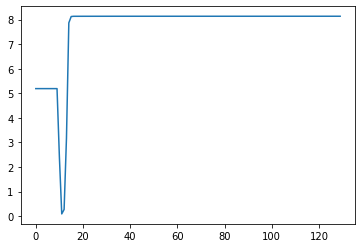

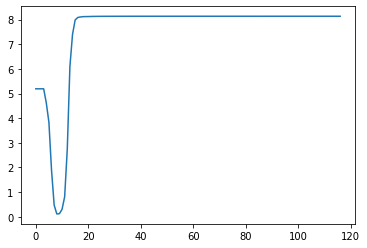

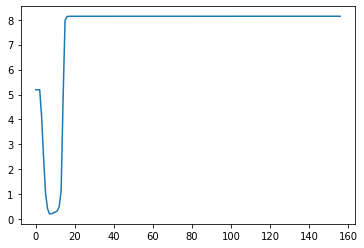

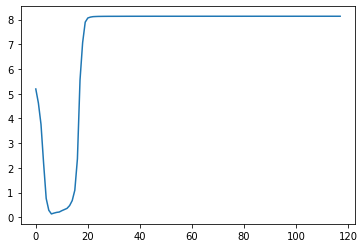

prova3


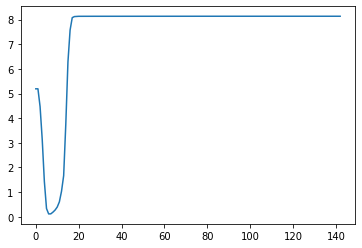

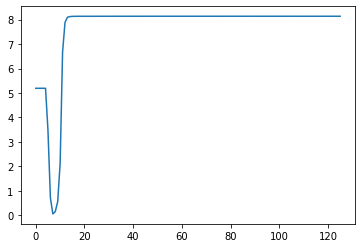

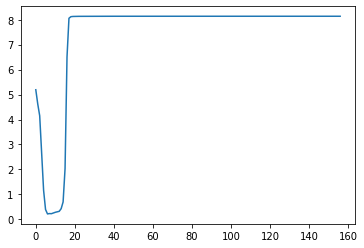

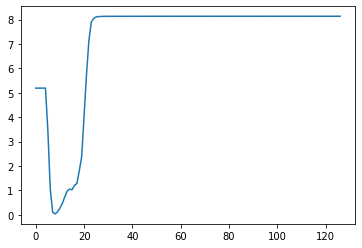

prova3


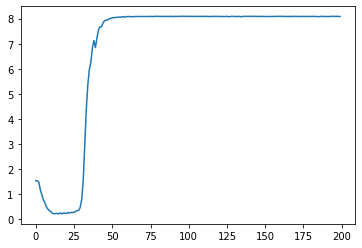

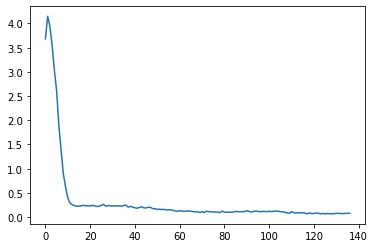

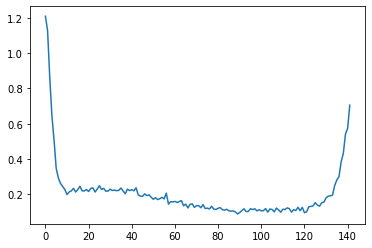

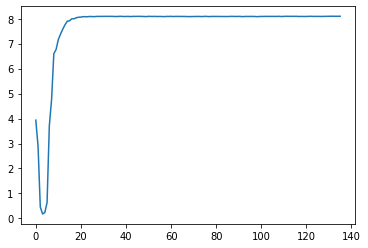

prova3


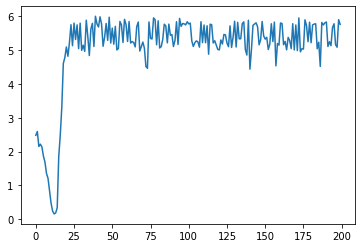

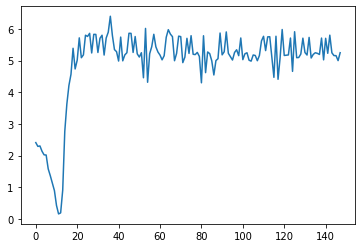

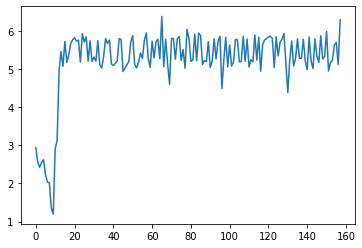

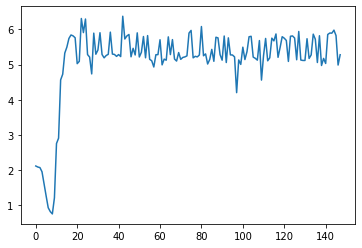

prova3


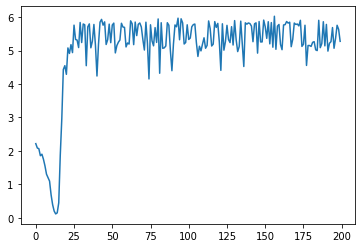

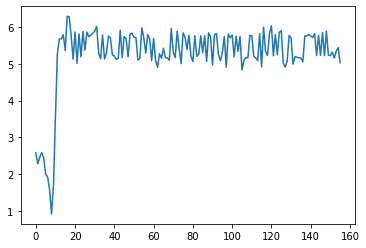

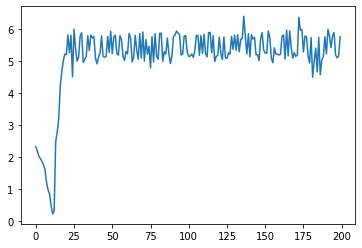

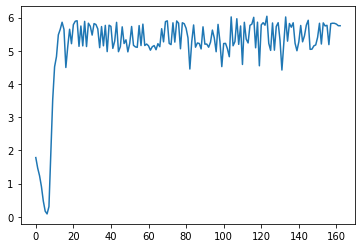

prova3


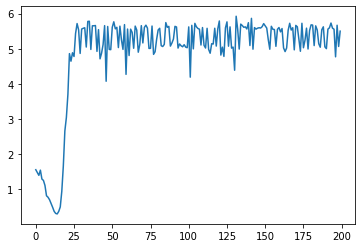

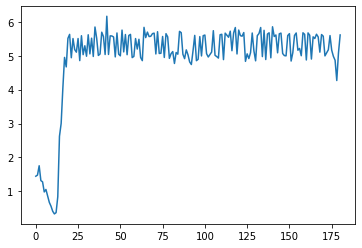

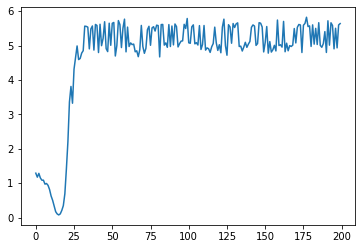

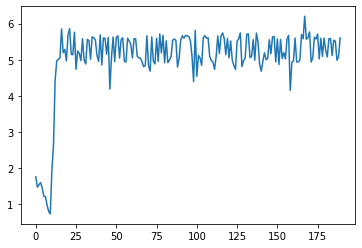

prova3


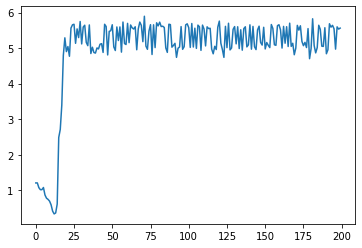

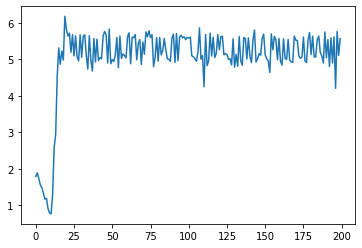

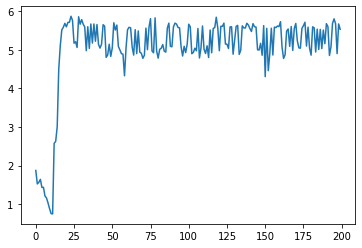

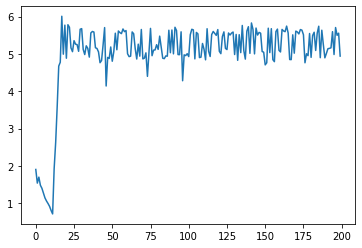

prova3


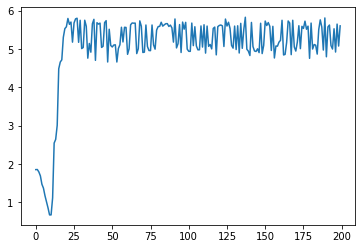

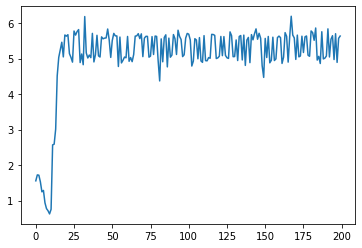

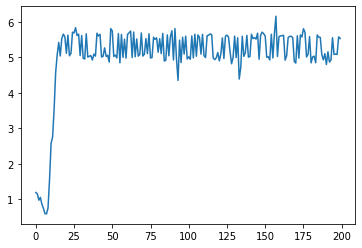

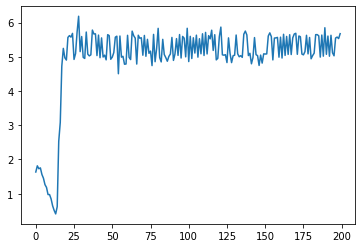

In [3]:
print("prova")
for i in range(0,34,2):
    print("prova3")
    for j in range (4):
        
        kl=np.loadtxt(f"KLdiv_LHC_s_3_3_2_10000_128_0.5_{i}_{j}")
       
        plt.plot(kl)
        plt.show()